# NIR photography for snowpit (Finse)

Assess usability of NIR photography for extracting SSA from NIR images taken from the Sony QX1/2.8 - 20mm pancake lens

See the paper by [Matzl and Schneebeli 2016](https://www.cambridge.org/core/journals/journal-of-glaciology/article/measuring-specific-surface-area-of-snow-by-nearinfrared-photography/C99FD080CFF5CC76EF77E5C85E4731AC) for more info

A calibration profile was derived from the camera with Micmac. This calibration profile is for correcting vigneting.

1. correct image for vignetting (calib profile is of the size of Raw images. Crop from center to use with jpegs
2. detrend if needed the luminosity, as it can vary linearly from top to bottom of the snowpit
3. sample targets for absolute reflectance calibration (white= 99%, and grey=50%). Fit a linear model $r=a+bi$, with $r$ being the reflectance, and $i$ the pixel intensity. 
4. Convert reflectance image to SSA with the conversion equation $SSA = Ae^{r/t}$ with $A=0.017 mm^{-1}$ and $t=12.222$. An optical diameter image can also be computed with: $d=6/SSA$ (d in mm).
5. Finally, use the ruler (or other object of know size) in image to scale image dimension to metric system.


TODO:
- write functions for all steps
- wrap all in a python package/class
- write function to extract profiles, and maybe later identify layers using reflectance/SSA, and contrast enhanced image
- write function to extract SSA profile to import in [niviz.org](www.niviz.org)
- include class to compute 

- Raw images are in 12 bit. Find a way to convert to BW from original while maintaining the 12bit resolution. [Rawpy](https://github.com/letmaik/rawpy) might be useful. Then make sure the processing pipeline can accept 12bit data (*i.e.* all skimage functions)
- wrap micmac function to extract profile 'mm3d vodka'. At least provide the method on how to do it.


In [1]:
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np

/home/arcticsnow/anaconda3/envs/dataAna/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
fname = '/home/arcticsnow/github/nirpy/data/DSC01343.JPG' 
fname_calib = '/home/arcticsnow/github/nirpy/data/SONY_QX1_SONY_28_20mm.tif'
img = sk.io.imread(fname)
calib = sk.io.imread(fname_calib).T

img_v = sk.color.rgb2hsv(img)[:,:,2]

# Crop calib profile, using center of matrix as cropping reference
def crop_center(img,crop_shape):
    y,x = img.shape
    startx = x//2 - crop_shape[1]//2
    starty = y//2 - crop_shape[0]//2    
    return img[starty:starty+crop_shape[0], startx:startx+crop_shape[1]]

calib = crop_center(calib, img_v.shape)

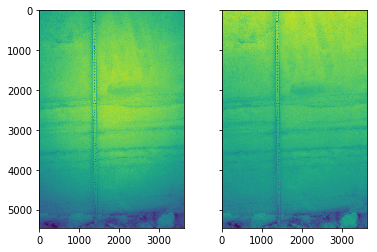

In [3]:
#%matplotlib
fig, axs = plt.subplots(1,2,sharex=True, sharey=True)
axs[0].imshow(img_v)
axs[1].imshow(img_v*calib)


In [6]:
# Compute linear trend of luminosty from top to bottom

means = np.mean(img_v*calib, axis=1)
trend = np.polyfit(np.arange(0,means.shape[0]),means,1)
trendpoly = np.poly1d(trend) 

In [12]:
# Compute corrected and detrended image
img_cor = img_v*calib- np.repeat(trendpoly(np.arange(0,means.shape[0])),img_v.shape[1], axis=0).reshape(img_v.shape)

fig, axs = plt.subplots(1,1, sharey=True)
axs.imshow(img_cor)
axs.plot([2000,2000], [0, img_v.shape[0]], 'k')
axs.plot(img_cor[:,2000]*5000+2000, np.arange(0,img_v.shape[0]), 'r')
plt.grid(linestyle=':', c='k')


In [13]:
# Show possibility to use contrast enhancement for visualization purpose

img_eq = sk.exposure.equalize_hist(img_cor)

fig, axs = plt.subplots(1,1, sharey=True)
axs.imshow(img_eq)
axs.plot([2000,2000], [0, img_v.shape[0]], 'k')
axs.plot(img_eq[:,2000]*1000+1000, np.arange(0,img_v.shape[0]), 'r')
plt.grid(linestyle=':', c='k')

## Calibrate Vignetting Method with Micmac

Micmac method to remove vignetting from an image. This calibration process provides a matrix of the size of the camera sensor, that is used by element-wise multiplication with the images. The calibration is camera/lens/focal lens dependend.

1. take multiple images of a none shiny surface in diffuse light
2. find tie points of with tapioca
```
mm3d Tapioca All .*ARW 2750
```
3. compute calibration matrix with vodka
```
mm3d Vodka .*ARW
```
4. If you want to apply the calibration directly:
```
mm3d Vodka .*ARW DoCor=1
```
